### Load beans data from tfds

In [ ]:
import tensorflow_datasets as tfds
import numpy as np

data, info = tfds.load('beans', with_info=True, shuffle_files=True, as_supervised=True)


### One-hot encode and decode

In [ ]:
def onehot_encode(arr, cat_num):
  return np.squeeze(np.eye(cat_num)[arr]).astype(np.int)
def onehot_decode(arr):
  return np.argmax(arr, axis=1)

### Get train data

In [ ]:
train_data = data['train']
x_train = np.zeros((1034, 500, 500, 3))
y_train = np.zeros((1034, 1))

i = 0
for x, l in train_data:
  x_train[i, :, :, :] = x
  y_train[i, :] = int(l)
  i+=1

y_train = y_train.astype(np.int)
# one-hot encode
y_train = onehot_encode(y_train, 3)


In [ ]:
print('x_train: ', x_train.shape)
print('y_train: ', y_train.shape)

x_train:  (1034, 500, 500, 3)
y_train:  (1034, 3)


### Get validation data

In [ ]:
val_data = data['validation']
x_val = np.zeros((134, 500, 500, 3))
y_val = np.zeros((134, 1))

i = 0
for x, l in val_data:
  x_val[i, :, :, :] = x
  y_val[i, :] = int(l)
  i+=1

y_val = y_val.astype(np.int)
# one-hot encode
y_val = onehot_encode(y_val, 3)


In [ ]:
print('x_val: ', x_val.shape)
print('y_val: ', y_val.shape)

x_val:  (134, 500, 500, 3)
y_val:  (134, 3)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)
train_data = train_datagen.flow(x_train, y_train, batch_size=10, shuffle=True)

val_datagen = ImageDataGenerator(rescale=1/255)
val_data = val_datagen.flow(x_val, y_val, batch_size=10, shuffle=True)

### Alternative options

In [ ]:
import tensorflow as tf

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(buffer_size=1024).batch(10)

In [ ]:
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.shuffle(buffer_size=1024).batch(10)

### Delete some variables to have more memory space

In [ ]:
del x_train
del y_train
del x_val
del y_val

### Plot samples in train data

NameError: ignored

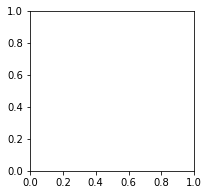

In [ ]:
% matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for i in range(1, 10):
  plt.subplot(3, 3, i)
  plt.imshow(x_train[i-1, :, :, :].astype('uint8'))

In [ ]:
import tensorflow as tf

class myCallBack(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_accuracy') > 0.95:
      print('Validation accuracy reach over 95%, stop training.')
      self.model.stop_training = True

base_model = tf.keras.applications.MobileNet(input_shape=(500, 500, 3), include_top=False, weights='imagenet')
base_model.trainable = False
output = base_model.output

x = tf.keras.layers.Flatten()(output)
x = tf.keras.layers.Dropout(0.2)(x, training=True)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x, training=True)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x, training=True)
x = tf.keras.layers.Dense(3, activation='softmax')(x)

callback = myCallBack()

model = tf.keras.Model(base_model.input, x)
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 501, 501, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 250, 250, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 250, 250, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 250, 250, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 250, 250, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 250, 250, 32)      128   

In [ ]:
model.fit(train_data, callbacks=[callback], epochs=20, verbose=1, validation_data=val_data)

Epoch 1/20
104/104 [==============================] - 13s 121ms/step - loss: 21.1652 - accuracy: 0.6847 - val_loss: 5.7026 - val_accuracy: 0.8358
Epoch 2/20
104/104 [==============================] - 12s 111ms/step - loss: 2.6301 - accuracy: 0.9062 - val_loss: 8.1879 - val_accuracy: 0.7463
Epoch 3/20
104/104 [==============================] - 12s 112ms/step - loss: 1.4596 - accuracy: 0.9313 - val_loss: 4.2143 - val_accuracy: 0.8582
Epoch 4/20
104/104 [==============================] - 12s 112ms/step - loss: 0.9647 - accuracy: 0.9632 - val_loss: 2.1356 - val_accuracy: 0.8731
Epoch 5/20
104/104 [==============================] - 12s 111ms/step - loss: 0.5674 - accuracy: 0.9662 - val_loss: 3.8311 - val_accuracy: 0.9030
Epoch 6/20
104/104 [==============================] - 12s 111ms/step - loss: 0.2088 - accuracy: 0.9874 - val_loss: 3.5461 - val_accuracy: 0.8955
Epoch 7/20
104/104 [==============================] - 12s 112ms/step - loss: 0.3605 - accuracy: 0.9807 - val_loss: 2.5004 - val_a

In [ ]:
test_data = data['test']
x_test = np.zeros((1034, 500, 500, 3))
y_test = np.zeros((1034, 1))

i = 0
for x, l in test_data:
  x_test[i, :, :, :] = x
  y_test[i, :] = int(l)
  i+=1


In [ ]:
model.evaluate(x_test, y_test)

### Build my network

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(500, 500, 3)),
                             tf.keras.layers.MaxPooling2D(2,2),
                             tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
                             tf.keras.layers.MaxPooling2D(2,2),
                             tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                             tf.keras.layers.MaxPooling2D(2,2),
                             tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                             tf.keras.layers.MaxPooling2D(2,2),
                             tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                             tf.keras.layers.MaxPooling2D(2,2),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dense(256, activation='relu'),
                             tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy')


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)
train_data = train_datagen.flow(x_train, y_train, batch_size=10)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 498, 498, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 249, 249, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 247, 247, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 121, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 64)        3

In [ ]:
model.fit(train_data, verbose=1, epochs=10)

Epoch 1/10
104/104 [==============================] - 11s 102ms/step - loss: 1.0377
Epoch 2/10
104/104 [==============================] - 10s 98ms/step - loss: 0.8442
Epoch 3/10
104/104 [==============================] - 10s 97ms/step - loss: 0.7010
Epoch 4/10
104/104 [==============================] - 10s 97ms/step - loss: 0.6534
Epoch 5/10
104/104 [==============================] - 10s 96ms/step - loss: 0.5915
Epoch 6/10
104/104 [==============================] - 10s 95ms/step - loss: 0.4794
Epoch 7/10
104/104 [==============================] - 10s 95ms/step - loss: 0.3662
Epoch 8/10
104/104 [==============================] - 10s 95ms/step - loss: 0.2878
Epoch 9/10
104/104 [==============================] - 10s 95ms/step - loss: 0.2253
Epoch 10/10
104/104 [==============================] - 10s 93ms/step - loss: 0.1660


In [ ]:
model.predict(x_train)